## Regresion Polinomial & Feature engineering

### Parte 1 - Modelo exponencial de covid-19 usando feature-eng

Utilizando un dataset de incidencias de covid-19 se desea crear un modelo de covid-19 para Guatemala, como propuesta se tiene el analizar la tendencia de los casos confirmados y en base a ello estimar un modelo con múltiples variables y en base a ese modelo se desea encontrar un mínimo estimado de casos confirmados para el día 30 de mayo del año 2020.

Para ésto procedemos cargando librerías y las consideraciones de compatibilidad de las mismas:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import seaborn as sns
import itertools
from datetime import datetime
%load_ext tensorboard

In [2]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


Cargamos el dataset y visualizamos un ejemplo de los datos:

In [3]:
covid19_data = pd.read_csv('./covid_19_clean_complete.csv')
covid19_data["Date"] = pd.to_datetime(covid19_data["Date"],infer_datetime_format = True)
covid19_data.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


Podemos ver que del dataset completo el alcance de nuestra investigación se limita al "Country/Region" de "Guatemala" y solo las incidencias con casos confirmados. Para generar el dataset resultante corremos los siguientes filtros: 

In [4]:
GT_confirmed = covid19_data[(covid19_data["Country/Region"] == 'Guatemala')& (covid19_data["Confirmed"] > 0)].copy()

Con objetivo de analizar el comportamiento de la cantidad de casos confirmados a lo largo del tiempo procedemos creando una gráfica para estimar a partir de ella un modelo que se ajuste a dico comportamiento.

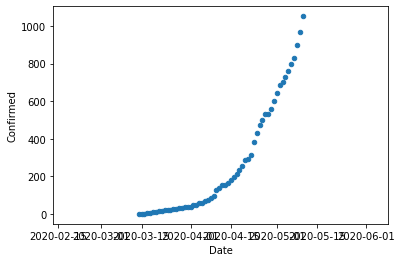

In [5]:
GT_confirmed.plot.scatter(x = "Date",y="Confirmed")

De donde podemos ver que tiene un aspecto de crecimiento exponencial, entonces considerando la búsqueda de una optimización de un modelo lineal (por las bondades que tiene el modelo) utilizaremos la variable del logaritmo natural de la cantidad de casos confirmados, ya que si la cantidad es exponencial entonces su logaritmo es lineal, lo cual lo vemos en lo siguiente:

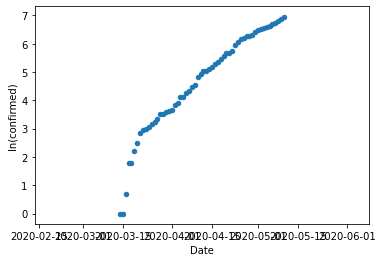

In [6]:
GT_confirmed["ln(confirmed)"] = np.log(GT_confirmed["Confirmed"])
GT_confirmed.plot.scatter(x = "Date",y="ln(confirmed)")

La gráfica anterior nos confirma que la hipótesis de convertir a logaritmo la variable nos daría un comportamiento similar a uno lineal.

Con el objetivo de utilizar la variable de tiempo en el modelo, necesitamos que sea representada por un valor numérico y proponemos a la variable que denote la cantidad de días transcurridos desde la primera ocasión de casos confirmados hasta la fecha de registro de la incidencia.

In [7]:
GT_confirmed["Dia_n"] =  (pd.to_datetime(GT_confirmed.Date) - pd.to_datetime(np.min(GT_confirmed.Date))).dt.days

Limpiamos nuestro dataset de variables categóricas que dada su distribución inducida por su significado consideramos no son capaces de generar aporte al modelo.

In [8]:
dataset = GT_confirmed[["Lat","Long","Dia_n","Deaths","Recovered","ln(confirmed)"]]

In [9]:
dataset.head()

,Lat,Long,Dia_n,Deaths,Recovered,ln(confirmed)
13851,15.7835,-90.2308,0,0,0,0.000000
14115,15.7835,-90.2308,1,0,0,0.000000
14379,15.7835,-90.2308,2,1,0,0.693147
14643,15.7835,-90.2308,3,1,0,1.791759
14907,15.7835,-90.2308,4,1,0,1.791759


Realizamos un breve análisis exploratorio de las variables para visualizar relación entre ellas:

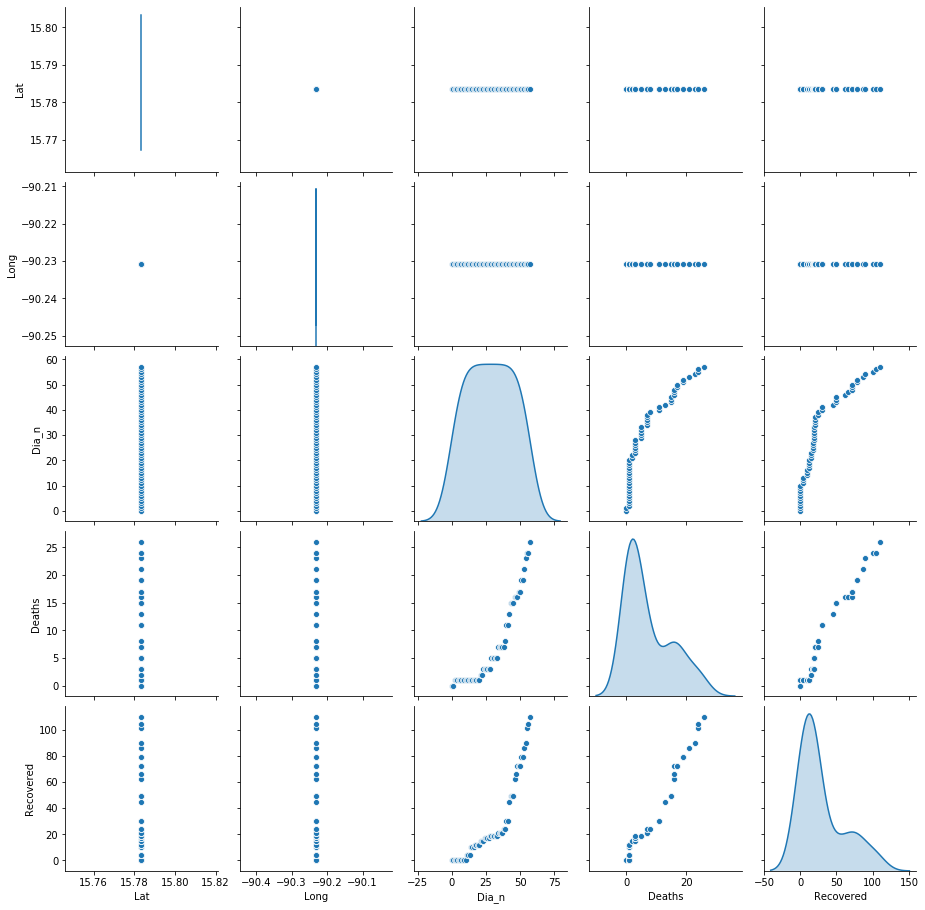

In [10]:
sns.pairplot(dataset[["Lat","Long","Dia_n","Deaths","Recovered"]], diag_kind="kde")

De dicha gráfica podemos comprobar que las variables longitud y latitud no tienen vaciación, por lo que las excluimos de nuestro análisis.

In [11]:
dataset = dataset[["Dia_n","Deaths","Recovered","ln(confirmed)"]]

Para realizar el modelo consideramos particionar la data en un 80% de las observaciones para el entrenamiento del mismo y el 20% restante para validar que los hiperparámetros obtenidos presenten un error bajo, de onde decidiremos si el modelo es útil o no.

In [12]:
tf.compat.v1.set_random_seed( 1 )
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [13]:
dataset.head()

,Dia_n,Deaths,Recovered,ln(confirmed)
13851,0,0,0,0.000000
14115,1,0,0,0.000000
14379,2,1,0,0.693147
14643,3,1,0,1.791759
14907,4,1,0,1.791759


Puesto que la librerría a utilizar es tensorflow y la metodología a optimizar será un "Batch Gradient Descent" creamos la clase ModeloLineal con el siguiente código para capacitarla de lo necesario según lo deseado.

In [14]:
class ModeloLineal:
  def __init__(self):
    tf.reset_default_graph()
    self.m = tf.get_variable("pendiente",dtype=tf.float32,shape=[1,3],initializer=tf.zeros_initializer())
    self.b = tf.get_variable("intercepto",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())

  def __call__(self,x):
    return tf.linalg.matmul(x, self.m,transpose_b=True) + self.b

  def actualizar(self,x,y,learning_rate):
    prediccion = self(x)
    error = 1/2*tf.reduce_mean(tf.math.square(y - prediccion) )
    gradiente = tf.gradients(error,[self.m,self.b])
    actualizacion_m = tf.assign(self.m, self.m - learning_rate*gradiente[0] )
    actualizacion_b = tf.assign(self.b, self.b - learning_rate*gradiente[1] )
    actualizacion_parametros = tf.group(actualizacion_m,actualizacion_b)

    return actualizacion_parametros

Creamos los arreglos del dataset de entrenamiento que serán utilizadas por la clase previamente descrita yel algoritmo siguiente para la optimización de hiperparámetros.

In [15]:
x = train_dataset.loc[:,["Dia_n","Deaths","Recovered"]]
y = train_dataset.loc[:,["ln(confirmed)"]]

In [16]:
modelo = ModeloLineal()
tamaño_muestra = len(x)

learning_rate = 0.000001

tensor_x = tf.placeholder(tf.float32,[tamaño_muestra,3],"tensor_x")
tensor_y = tf.placeholder(tf.float32,[tamaño_muestra,1],"tensor_y")

prediccion = modelo(tensor_x)
actualizacion_parametros = modelo.actualizar(tensor_x,tensor_y,learning_rate)

with tf.train.MonitoredSession() as session:
    feed_dict = {tensor_x:x, tensor_y:y}

    for i in range(500):
    
        session.run(actualizacion_parametros,feed_dict=feed_dict)
        predicciones = session.run(prediccion,feed_dict=feed_dict)

    pendiente_final,intercepto_final = session.run([modelo.m,modelo.b],feed_dict=feed_dict)
    

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Observamos los hiperparámetros resultantes.

In [17]:
pendiente_final,intercepto_final

(array([[0.04602113, 0.01122416, 0.04412961]], dtype=float32), 0.0015119675)

Con los valores obtenidos de hiperparámetros construimos el error del modelo aplicado al conjunto de datos de prueba y observamos los mismos.

In [18]:
x_test = test_dataset.loc[:,["Dia_n","Deaths","Recovered"]]
y_test = test_dataset.loc[:,["ln(confirmed)"]]
prediccion_test =tf.linalg.matmul(tf.cast(x_test, tf.float32), pendiente_final,transpose_b=True) + intercepto_final
error = 1/2*tf.reduce_mean(tf.math.square(tf.cast(y_test, tf.float32) - prediccion_test) )
error2 = 1/2*tf.reduce_mean(tf.math.square(tf.cast(np.e**y_test, tf.float32) - np.e**prediccion_test) )
error3 = 1/2*tf.reduce_mean(tf.math.square(tf.cast(np.e**y_test, tf.float32) - np.e**np.mean(y)) )

In [19]:
with tf.Session() as sess: 
    print("Error al aplicar el modelo sobre el conjunto de prueba, en la escala logarirmica: ", error.eval())
    print("Error al aplicar el modelo sobre el conjunto de prueba, en la escala normal: ",error2.eval())
    print("Error al aplicar un fit del promedio sobre el conjunto de pueba: ",error3.eval()) 

Error al aplicar el modelo sobre el conjunto de prueba, en la escala logarirmica:  2.0381896
Error al aplicar el modelo sobre el conjunto de prueba, en la escala normal:  34209.34
Error al aplicar un fit del promedio sobre el conjunto de pueba:  68775.914


De los errore obtenidos vemos que nuestra estimación por medio del modelo lineal es significativamente mejor que utilizar el promedio como valor de estimación. Por lo que ahora procedemos a estimar el valor de casos confirmados en Guatemala para el 30 de mayo del 2020.

In [20]:
Dia_D = (pd.to_datetime('2020-05-30') - min(GT_confirmed.Date)).days
max_death = np.max(dataset["Deaths"])
max_recover = np.max(dataset["Recovered"])

In [21]:
confirmados_hat_DD = np.dot(pendiente_final[0], [Dia_D,max_death,max_recover]) + intercepto_final
print(np.e**confirmados_hat_DD)

5950.45857017506


Por lo tanto el estimado de casos según el modelo aplicado es de al menos 5950, ya que al no tener una estimación de los casos de muertes y recuperados y aprovechando el valor del coeficiente en estas variables es positivo entonces a más casos en esa variable más casos en nuestra variable objetivo, entonces al tomar el valor máximo obtenemos un mínimo para nuestra estimación.

### Parte 2 - Modelo polinomial de calidad de vinos

In [22]:
data = pd.read_csv('winequality-red.csv')

In [23]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


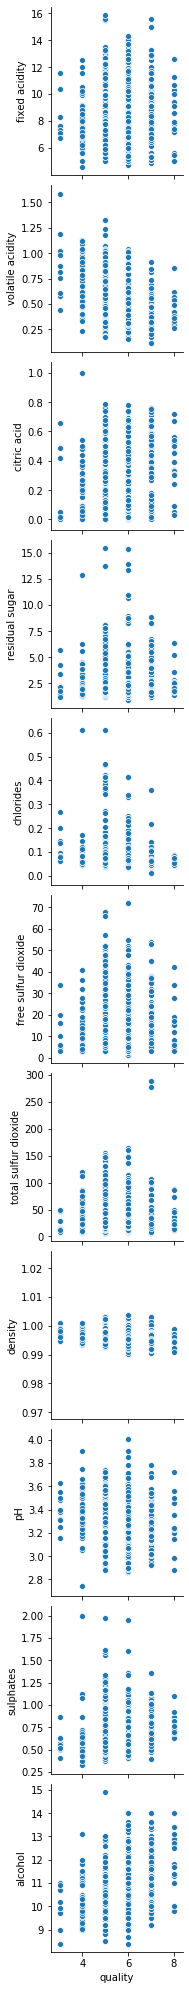

In [24]:
pp = sns.pairplot(data=data,
                  x_vars=['quality'],
                  y_vars=['fixed acidity', 'volatile acidity',
                          'citric acid','residual sugar','chlorides',
                         'free sulfur dioxide','total sulfur dioxide',
                         'density','pH','sulphates','alcohol'])

De la imagen vemos que no podemos proceder con la eliminación de variable alguna, por lo que procedemos con una sencilla manipulación de las mismsas con la esperanza que la combinación genere algún valor a nosotros. Dicho valor lo consideraremos como el ajuste que la variable tiene sobre nuestra variable obtenida, considerando el ajuste como un modelo lineal con los conjuntos de entrenamiento y validación.

In [25]:
class ModeloLineal:
  def __init__(self):
    tf.reset_default_graph()
    self.m = tf.get_variable("pendiente",dtype=tf.float32,shape=[1,5],initializer=tf.zeros_initializer())
    self.b = tf.get_variable("intercepto",dtype=tf.float32,shape=[],initializer=tf.zeros_initializer())

  def __call__(self,x):
    return tf.linalg.matmul(x, self.m,transpose_b=True) + self.b

  def actualizar(self,x,y,learning_rate):
    prediccion = self(x)
    error = 1/2*tf.reduce_mean(tf.math.square(y - prediccion) )
    with tf.name_scope("Error"):
            error_summary = tf.summary.scalar(name = "ErrorSummary", tensor = error)
    gradiente = tf.gradients(error,[self.m,self.b])
    actualizacion_m = tf.assign(self.m, self.m - learning_rate*gradiente[0] )
    actualizacion_b = tf.assign(self.b, self.b - learning_rate*gradiente[1] )
    actualizacion_parametros = tf.group(actualizacion_m,actualizacion_b)

    return actualizacion_parametros,error_summary

In [26]:
def Probar_Variable(var1,var2,x_train,y_train,x_test,y_test,learning_rate = 0.000001,epochs = 500):

    modelo = ModeloLineal()
    tamaño_muestra = len(x_train)
    
    tensor_x = tf.placeholder(tf.float32,[tamaño_muestra,5],"tensor_x")
    tensor_y = tf.placeholder(tf.float32,[tamaño_muestra,],"tensor_y")
    now = datetime.now()
    logdir = "./tf_logs/" + now.strftime("%Y%m%d-%H%M%S") +"_lr_"+str(learning_rate) + "_epochs_" + str(epochs) + "_var1_" + str(var1) + "_var2_" + str(var2) 
    prediccion = modelo(tensor_x)
    actualizacion_parametros = modelo.actualizar(tensor_x,tensor_y,learning_rate)

    with tf.train.MonitoredSession() as session:
        train_writer = tf.summary.FileWriter( logdir, session.graph)
        
        feed_dict = {tensor_x:x_train, tensor_y:y_train}

        for i in range(epochs):

            la_actualizacion = session.run(actualizacion_parametros,feed_dict=feed_dict)
            #merge = tf.summary.merge_all()
            train_writer.add_summary(la_actualizacion[1],i)
            predicciones = session.run(prediccion,feed_dict=feed_dict)

        pendiente_final,intercepto_final = session.run([modelo.m,modelo.b],feed_dict=feed_dict)
        
        prediccion_test = session.run(prediccion,feed_dict=feed_dict)
        
        
        
    return  1/2*tf.reduce_mean(tf.math.square(tf.cast(y_test, tf.float32) - prediccion_test) ),pendiente_final,intercepto_final
    

In [27]:
#errores = []
#for i in list(itertools.combinations(range(data.shape[1]-1), 2)):
#    d = {'a': np.array(data.iloc[:,i[0]]),
#         'b': np.array(data.iloc[:,i[1]]),
#         'a^2': np.array(data.iloc[:,i[0]])*np.array(data.iloc[:,i[0]]),
#         'b^2': np.array(data.iloc[:,i[1]])*np.array(data.iloc[:,i[1]]),
#         'ab': np.array(data.iloc[:,i[0]])*np.array(data.iloc[:,i[1]]),
#         'y' : np.array(data.iloc[:,11])}
#    dataset = pd.DataFrame(data=d)
#    tf.compat.v1.set_random_seed( 2 )
#    train_dataset = dataset.sample(frac=0.8,random_state=0)
#    test_dataset = dataset.drop(train_dataset.index)
#    x_train = train_dataset[["a","b","a^2","b^2","ab"]]
#    y_train = train_dataset["y"]
#    x_test = test_dataset[["a","b","a^2","b^2","ab"]]
#    y_test = test_dataset["y"]
#    resultados_i = Probar_Variable(i[0],i[1],x_train,y_train,x_test,y_test)
#    errores.append([i,resultados_i])

In [28]:
%tensorboard --logdir .tf_logs

Reusing TensorBoard on port 6006 (pid 24452), started 0:14:32 ago. (Use '!kill 24452' to kill it.)

Ahora podemos visualizar las gráficas de errores apoyados en la herramienta Tensorboard, de manera que veremos a cada variable y cómo interactúa con las demás para así determinar que parejas de variables hacen el mejor fit.

#### Errores variable 0 (fixed acidity)
<img src="Graphs/Errores_v0_all.png">

#### Errores variable 1 (volatile acidity)
<img src="Graphs/Errores_v1_all.png">

#### Errores variable 2 (citric acid)
<img src="Graphs/Errores_v2_all.png">

#### Errores variable 3 (residual sugar)
<img src="Graphs/Errores_v3_all.png">

#### Errores variable 4 (chlorides)
<img src="Graphs/Errores_v4_all.png">

#### Errores variable 5 (free sulfur dioxide)
<img src="Graphs/Errores_v5_all.png">

#### Errores variable 6 (total sulfur dioxide )
<img src="Graphs/Errores_v6_all.png">

#### Errores variable 7 (density)
<img src="Graphs/Errores_v7_all.png">

#### Errores variable 8 (pH)
<img src="Graphs/Errores_v8_all.png">

#### Errores variable 9 (sulphates)
<img src="Graphs/Errores_v9_all.png">

#### Errores variable 10 (alcohol)
<img src="Graphs/Errores_v10_all.png">

De las gráficas vemos que la variable que es capaz de mejorar a las demás es la variable 10 que es la que denota el alcohol, entonces para minimizar computación procedemos con las mejores 2 parejas de la combinación con la variable 10, que son la variable 8 (pH)  y la variable 0 (fixed acidity).


In [29]:
vect_piv = [0,8,10]
data2 = data[["fixed acidity","pH","alcohol","quality"]]

In [30]:
errores2 = []
for i in list(itertools.combinations(range(data2.shape[1]-1), 2)):
    d = {'a': np.array(data2.iloc[:,i[0]]),
         'b': np.array(data2.iloc[:,i[1]]),
         'a^2': np.array(data2.iloc[:,i[0]])*np.array(data.iloc[:,i[0]]),
         'b^2': np.array(data2.iloc[:,i[1]])*np.array(data.iloc[:,i[1]]),
         'ab': np.array(data2.iloc[:,i[0]])*np.array(data.iloc[:,i[1]]),
         'y' : np.array(data2.iloc[:,3])}
    dataset = pd.DataFrame(data=d)
    tf.compat.v1.set_random_seed( 2 )
    train_dataset = dataset.sample(frac=0.8,random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    x_train = train_dataset[["a","b","a^2","b^2","ab"]]
    y_train = train_dataset["y"]
    x_test = test_dataset[["a","b","a^2","b^2","ab"]]
    y_test = test_dataset["y"]
    resultados_i = Probar_Variable(vect_piv[i[0]],vect_piv[i[1]],x_train,y_train,x_test,y_test,learning_rate = 0.00001,epochs = 1000)
    errores2.append([i,resultados_i])

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [34]:
%tensorboard --logdir .tf_logs --6006

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT] [--master_tpu_unsecure_channel ADDR]
                   {serve,dev} ...
tensorboard: error: unrecognized arguments: --6006